# [**Estimations OOB de l'amplification de gradient**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/1_11_ensembles/plot_gradient_boosting_oob.ipynb)<br/>([*Gradient Boosting Out-of-Bag estimates*](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_oob.html))

Les estimations out-of-bag (OOB) peuvent être une heuristique utile pour estimer le nombre "optimal" d'itérations de boosting. Les estimations OOB sont presque identiques aux estimations de validation croisée, mais elles peuvent être calculées à la volée sans nécessiter d'ajustement répété du modèle. Les estimations OOB ne sont disponibles que pour Stochastic Gradient Boosting (c'est-à-dire `subsample < 1.0`), les estimations sont dérivées de l'amélioration de la perte basée sur les exemples non inclus dans l'échantillon bootstrap (les exemples dits hors sac). L'estimateur OOB est un estimateur pessimiste de la vraie perte de test, mais reste une assez bonne approximation pour un petit nombre d'arbres.

La figure montre la somme cumulée des améliorations OOB négatives en fonction de l'itération de boosting. Comme vous pouvez le voir, il suit la perte de test pour les cent premières itérations, mais diverge ensuite de manière pessimiste. La figure montre également les performances de la validation croisée triple qui donne généralement une meilleure estimation de la perte de test mais est plus exigeante en termes de calcul.

Accuracy: 0.6800


c:\Users\franc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)


clf.loss_ <sklearn.ensemble._gb_losses.BinomialDeviance object at 0x00000218B6791D00>


c:\Users\franc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)


clf.loss_ <sklearn.ensemble._gb_losses.BinomialDeviance object at 0x00000218B67B6F40>


c:\Users\franc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
c:\Users\franc\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)


clf.loss_ <sklearn.ensemble._gb_losses.BinomialDeviance object at 0x00000218B67B66D0>
clf.loss_ <sklearn.ensemble._gb_losses.BinomialDeviance object at 0x00000218B65E68E0>


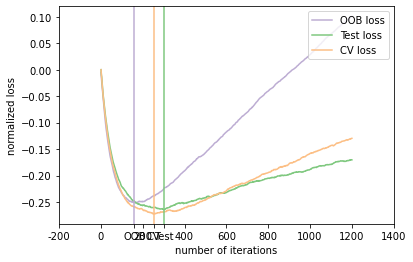

In [8]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from sklearn.ensemble._gb_losses import BinomialDeviance as binomial_deviance

from scipy.special import expit

# Generate data (adapted from G. Ridgeway's gbm example)
n_samples = 1000
random_state = np.random.RandomState(13)
x1 = random_state.uniform(size=n_samples)
x2 = random_state.uniform(size=n_samples)
x3 = random_state.randint(0, 4, size=n_samples)

p = expit(np.sin(3 * x1) - 4 * x2 + x3)
y = random_state.binomial(1, p, size=n_samples)

X = np.c_[x1, x2, x3]

X = X.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=9)

# Fit classifier with out-of-bag estimates
params = {
    "n_estimators": 1200,
    "max_depth": 3,
    "subsample": 0.5,
    "learning_rate": 0.01,
    "min_samples_leaf": 1,
    "random_state": 3,
}
clf = ensemble.GradientBoostingClassifier(**params)

clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print("Accuracy: {:.4f}".format(acc))

n_estimators = params["n_estimators"]
x = np.arange(n_estimators) + 1


def heldout_score(clf, X_test, y_test):
    """compute deviance scores on ``X_test`` and ``y_test``."""
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        if i == 0:
            print('clf.loss_', clf.loss_)
        score[i] = clf.loss_(y_test, y_pred)
        # score[i] = log_loss(y_test, y_pred)   # clf.loss_ : depr 1.1 and rmv 1.3
    return score


def cv_estimate(n_splits=None):
    cv = KFold(n_splits=n_splits)
    cv_clf = ensemble.GradientBoostingClassifier(**params)
    val_scores = np.zeros((n_estimators,), dtype=np.float64)
    for train, test in cv.split(X_train, y_train):
        cv_clf.fit(X_train[train], y_train[train])
        val_scores += heldout_score(cv_clf, X_train[test], y_train[test])
    val_scores /= n_splits
    return val_scores


# Estimate best n_estimator using cross-validation
cv_score = cv_estimate(3)

# Compute best n_estimator for test data
test_score = heldout_score(clf, X_test, y_test)

# negative cumulative sum of oob improvements
cumsum = -np.cumsum(clf.oob_improvement_)

# min loss according to OOB
oob_best_iter = x[np.argmin(cumsum)]

# min loss according to test (normalize such that first loss is 0)
test_score -= test_score[0]
test_best_iter = x[np.argmin(test_score)]

# min loss according to cv (normalize such that first loss is 0)
cv_score -= cv_score[0]
cv_best_iter = x[np.argmin(cv_score)]

# color brew for the three curves
oob_color = list(map(lambda x: x / 256.0, (190, 174, 212)))
test_color = list(map(lambda x: x / 256.0, (127, 201, 127)))
cv_color = list(map(lambda x: x / 256.0, (253, 192, 134)))

# plot curves and vertical lines for best iterations
plt.plot(x, cumsum, label="OOB loss", color=oob_color)
plt.plot(x, test_score, label="Test loss", color=test_color)
plt.plot(x, cv_score, label="CV loss", color=cv_color)
plt.axvline(x=oob_best_iter, color=oob_color)
plt.axvline(x=test_best_iter, color=test_color)
plt.axvline(x=cv_best_iter, color=cv_color)

# add three vertical lines to xticks
xticks = plt.xticks()
xticks_pos = np.array(
    xticks[0].tolist() + [oob_best_iter, cv_best_iter, test_best_iter]
)
xticks_label = np.array(list(map(lambda t: int(t), xticks[0])) + ["OOB", "CV", "Test"])
ind = np.argsort(xticks_pos)
xticks_pos = xticks_pos[ind]
xticks_label = xticks_label[ind]
plt.xticks(xticks_pos, xticks_label)

plt.legend(loc="upper right")
plt.ylabel("normalized loss")
plt.xlabel("number of iterations")

plt.show()